# Question 2

---

## 1. SABR formula

In [1]:
# import modules
import numpy as np
from scipy.stats import norm

import pandas as pd
from collections import OrderedDict

import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

First, implement the Black-Scholes formula to which we will feed the implied volatility computed according via SABR:

In [2]:
# Black-Scholes Formula
def BlackScholes(S = 100, K = 100, r = 0.0, sigma = 0.15, T = 1):
    d1 = (np.log(S / K) + (r + 0.5*(sigma ** 2)) * T)/(sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

The SABR formula as published by Hagan et al. (2002) has a few internal flaws. For this reason, the implementation is done as advocated in [Obloj (2008)](https://arxiv.org/pdf/0708.0998v3.pdf) (eqn. 2).

In [3]:
D = lambda x, rho: np.log((np.sqrt(1-2*rho*x+x**2)+x-rho)/(1-rho))

In [4]:
# SABR implied volatility 
def sigma(F0, K, T, sigma0, alpha, beta, rho):
    if F0 == K or (alpha == 0 and beta == 1):
        I0 = sigma0*K**(beta-1)
    elif alpha == 0:
        I0 = np.log(F0/K)*sigma0*(1-beta)/(F0**(1-beta)-K**(1-beta))
    elif beta == 1:
        I0 = alpha * np.log(F0/K) / D(alpha/sigma0*np.log(F0/K),rho)
    elif beta < 1:
        I0 = alpha*np.log(F0/K)/D(alpha/(sigma0*(1-beta))*(F0**(1-beta)-K**(1-beta)),rho)
    I1 = (sigma0*(1-beta))**2 / (24*(F0*K)**(1-beta)) \
        + 0.25*rho*beta*alpha*sigma0 / (F0*K)**((1-beta)/2) \
        + (2-3*rho**2)/24*alpha**2
    return I0*(1+I1*T)

Next, we are interested in applying the formula to our selection of inputs, which we read in the following dataframe:

In [5]:
df1 = pd.DataFrame(OrderedDict({'Spot' : [100]*10,
                                 'Strike' : [100, 70, 130]*3 + [150],
                                 'Maturity' : [1, 3, 3, 3, 5, 5, 5, 10, 10, 10],                                
                                 'Sigma' : [0.15, 1.5, 4.74]*3 + [0.15],                                
                                 'Alpha' : [0.25, 0.2, 0.3, 0.05, 0.5, 0.25, 0.3, 0.25, 0.2, 0.25],
                                 'Beta' : [1, 0.5, 0.25]*3 + [1],
                                 'Rho' : [0, -0.5, -0.75, 0.5, 0.75, 0, 0.5, 0.75, -0.5, -0.75]
                                }))

In [6]:
%%time
# Run the formula and store results in 2 new columns:
df1['implVol'] = 0.0
df1['SABR'] = 0.0
for i in range(len(df1)):
    F0, K, T, sigma0, alpha, beta, rho = df1.loc[i][:7]
    df1.loc[i,'implVol'] = sigma(F0, K, T, sigma0, alpha, beta, rho)
    df1.loc[i,'SABR'] = BlackScholes(S=F0, K=K, T=T,
                                sigma=sigma(F0, K, T, sigma0, alpha, beta, rho))

Wall time: 56 ms


In [7]:
df1

,Spot,Strike,Maturity,Sigma,Alpha,Beta,Rho,implVol,SABR
0,100,100,1,0.15,0.25,1.00,0.00,0.150781,6.009608
1,100,70,3,1.50,0.20,0.50,-0.50,0.184155,31.751477
2,100,130,3,4.74,0.30,0.25,-0.75,0.109343,0.815159
3,100,100,3,0.15,0.05,1.00,0.50,0.150480,10.368667
4,100,70,5,1.50,0.50,0.50,0.75,0.128541,31.231053
5,100,130,5,4.74,0.25,0.25,0.00,0.144567,4.307074
6,100,100,5,0.15,0.30,1.00,0.50,0.157734,13.998290
7,100,70,10,1.50,0.25,0.50,0.75,0.140284,34.366243
8,100,130,10,4.74,0.20,0.25,-0.50,0.127301,7.031888
9,100,150,10,0.15,0.25,1.00,-0.75,0.110415,2.569900


We managed to reproduce the SABR prices given as benchmarks.

---

## 2. Monte Carlo simulations for SABR

### a. Derive $\alpha$ and $\beta$

The correlation is computed as follows:
$$Corr\left(\tilde{N_2},N_1\right) = \frac{Cov\left(\tilde{N}_2,N_1\right)}{\sqrt{Var\left(\tilde{N}_2\right)}\sqrt{Var\left(N_1\right)}}$$

The explicit form is reached by computing the covariance and variances:

\begin{align*}
Cov\left(\tilde{N}_2,N_1\right) & = E\left[\left(\tilde{N}_2-E\left(\tilde{N}_2\right)\right)\left(N_1-E\left(N_1\right)\right)\right]\\
& = E\left[\tilde{N}_2N_1\right] \\
& = E\left[\left(\alpha N_1 + \beta N_2\right)N_1\right]\\
& = E\left[\alpha N_1^2\right]\\
& = \alpha
\end{align*}

\begin{align*}
Var\left(\tilde{N}_2\right) & = E\left[\left(\tilde{N}_2-E\left(\tilde{N}_2\right)\right)^2\right]\\
& = E\left[\tilde{N}_2^2\right] \\
& = E\left[\left(\alpha N_1 + \beta N_2 \right)^2\right]\\
& = \alpha^2 + \beta^2
\end{align*}

And $Var\left(N_1\right) = 1$ by assumption.

To find our $\alpha$ and $\beta$, we must have:


\begin{equation*}
    \begin{cases}
        Var\left(\tilde{N}_2\right) = 1, \\ 
        Corr\left(\tilde{N}_2,N_1\right) = \rho
    \end{cases} \quad
\Leftrightarrow \quad
    \begin{cases}
        \alpha^2+\beta^2 = 1, \\ 
        \alpha = \rho
    \end{cases}
\Leftrightarrow \quad
    \begin{cases}
        \alpha = \rho, \\ 
        \beta = \sqrt{1-\rho^2}
    \end{cases}
\end{equation*}

### b. Euler scheme implementation

The following function implements the Monte-Carlo simulations for SABR. The implementation treats zero as an absorbing boundary. That is, if the path reaches zero it will remain at this level till maturity.

In [8]:
def MonteCarlo_SABR(spot, strike, T, sigma0, alpha, beta, rho, nPaths, nSteps):
    dt = T / nSteps
    S = np.full(nPaths, spot)
    logSigma = np.full(nPaths, np.log(sigma0))
    
    for i in range(nSteps):
        idx = S > 0        
        N1, N2 = np.random.normal(size=(2,idx.sum()))
        N2 = rho * N1 + np.sqrt(1-rho**2) * N2
        S[idx] = S[idx] + np.exp(logSigma[idx]) * S[idx]**beta * np.sqrt(dt) * N1
        logSigma[idx] = logSigma[idx] - 0.5 * alpha**2*dt + alpha * np.sqrt(dt) * N2

    return np.mean(np.maximum(S - strike, 0))

### c. Results

Taking the number of paths (simulations) to be equal to 10000 and the number of steps equal to 252 per year, we run once our Monte Carlo SABR simulation for each entry in our table:

In [9]:
%%time
df1['MC SABR'] = 0.0
for i in range(len(df1)):
    spot, strike, T, sigma0, alpha, beta, rho = df1.loc[i][:7]
    df1.loc[i,'MC SABR'] = MonteCarlo_SABR(spot, strike, T, sigma0, alpha, beta, rho, 10000, int(252*T))

Wall time: 29 s


In [10]:
df1

,Spot,Strike,Maturity,Sigma,Alpha,Beta,Rho,implVol,SABR,MC SABR
0,100,100,1,0.15,0.25,1.00,0.00,0.150781,6.009608,5.873263
1,100,70,3,1.50,0.20,0.50,-0.50,0.184155,31.751477,32.001474
2,100,130,3,4.74,0.30,0.25,-0.75,0.109343,0.815159,0.824826
3,100,100,3,0.15,0.05,1.00,0.50,0.150480,10.368667,10.814899
4,100,70,5,1.50,0.50,0.50,0.75,0.128541,31.231053,32.125685
5,100,130,5,4.74,0.25,0.25,0.00,0.144567,4.307074,4.254719
6,100,100,5,0.15,0.30,1.00,0.50,0.157734,13.998290,13.729044
7,100,70,10,1.50,0.25,0.50,0.75,0.140284,34.366243,33.459083
8,100,130,10,4.74,0.20,0.25,-0.50,0.127301,7.031888,7.021663
9,100,150,10,0.15,0.25,1.00,-0.75,0.110415,2.569900,2.526734


### d. Convergence

We will look at the case with with high sigma and high correlation which we might expect to be the slowest in convergence. That corresponds to the 3rd row in the table above.

To assess the convergence we will collect results from 30 simulations for different number of steps and for several number of paths. The standard deviations and means will be collected in the `table` dataframe.

In [11]:
paths = 10**np.arange(1,5,0.5)
steps = 10**np.arange(0.75,3.5,0.25)
times = 30

In [12]:
table = np.full((len(paths),len(steps),2), 0.0)
simulations = np.full((len(steps),times), 0.0)

In [13]:
%%time
spot, strike, T, sigma0, alpha, beta, rho = df1.loc[2][:7]
for i, nP in enumerate(paths):
    for j, nS in enumerate(steps):
        simulations[j] = [MonteCarlo_SABR(spot, strike, T, sigma0, alpha, beta, rho, 
                                          int(nP), int(nS*T)) for t in range(times)]
    table[i] = np.array([simulations.mean(axis=1),simulations.std(axis=1)]).T

Wall time: 1h 11min 27s


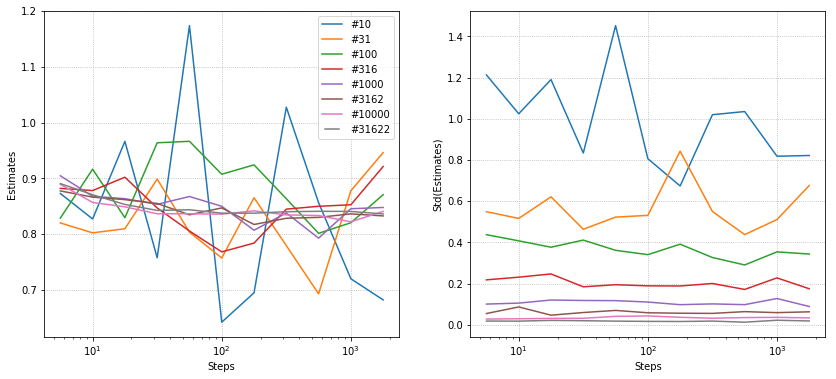

In [14]:
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
for i in range(len(paths)):
    line1, = plt.semilogx(steps, table[i][:,0], label='#'+str(int(paths[i])))
plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})
plt.xlabel('Steps')
plt.ylabel('Estimates')
plt.grid(True,linestyle='dotted')

plt.subplot(1, 2, 2)
for i in range(len(paths)):
    line1, = plt.semilogx(steps, table[i][:,1], label='#'+str(int(paths[i])))
plt.xlabel('Steps')
plt.ylabel('Std(Estimates)')
plt.grid(True,linestyle='dotted')

plt.show()

It seems that 10000 simulations (paths) are enough to provide fairly good estimate. Let us look closer at how the mean behaves with varying number of steps. Apart from this we would want to see also that the standard deviation of the estimate goes to zero.

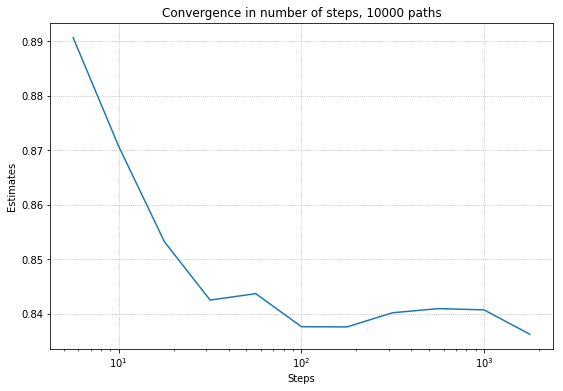

In [15]:
# Plot results

plt.figure(figsize=(9,6))

plt.semilogx(steps, table[-1][:,0])

plt.xlabel('Steps')
plt.ylabel('Estimates')
plt.title('Convergence in number of steps, 10000 paths')

plt.grid(True,linestyle='dotted')

plt.show()

Time it takes to run a simulation:

In [16]:
spot, strike, T, sigma0, alpha, beta, rho = df1.loc[2][:7]

In [17]:
%%timeit
MonteCarlo_SABR(spot, strike, T, sigma0, alpha, beta, rho, 10000, int(252*T))

2.19 s ± 308 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


---

## 3. Monte Carlo for Heston

### a. 

Apply Ito's lemma to $\ln S_t$:

\begin{align*}
d\ln S_t & = \frac{\partial \ln S_t}{\partial S_t}dS_t + \frac{1}{2}\frac{\partial^2 \ln S_t}{\partial S_t^2} \left(dS_t\right)^2 \\
& = \lambda \sqrt{\nu} dW^S - \frac{1}{2} \lambda^2 \nu d t
\end{align*}


Euler's scheme is readily available: 

$$\ln(S_{t+1}) = \ln(S_{t}) - \frac{1}{2}\lambda^2 \nu \Delta t + \lambda \sqrt{\nu} \sqrt{\Delta t}\; N $$

### b.
#### i. Expectation and variance of $\nu_{i+1}$

Expectation is computed as follows:

\begin{align*}
E\left[x e^{-\frac{y^2}{2}+yN^{\nu}}\right] & = \int_{-\infty}^{+\infty} x e^{-\frac{y^2}{2}+y \:z} \phi(z) dz\\
& = x e^{-\frac{y^2}{2}} \int_{-\infty}^{+\infty} e^{y \:z} \; \frac{1}{\sqrt{2\pi}} e^{-\frac{z^2}{2}} dz\\
& = x e^{-\frac{y^2}{2}} \int_{-\infty}^{+\infty} \frac{1}{\sqrt{2\pi}} e^{-\frac{z^2-2yz+y^2-y^2}{2}} dz\\
& = x e^{-\frac{y^2}{2}} \int_{-\infty}^{+\infty} \frac{1}{\sqrt{2\pi}} e^{-\frac{(z-y)^2}{2}}e^{y^2} dz\\
&= x \int_{-\infty}^{+\infty} \frac{1}{\sqrt{2\pi}} e^{-\frac{(z-y)^2}{2}} dz\\
& = x
\end{align*}

Alternatively, we may notice that $\nu_{T_{i+1}}/x$ is lognormally distributed. From the properties of this distribution we find 
that $E\left[\nu_{T_{i+1}}/x\right]=1$ and therefore $E\left[\nu_{T_{i+1}}\right]=x$

To save space, again, we will use the properties of the lognormal distribution to find the variance:

\begin{align*}
Var\left[\nu_{T_{i+1}}/x\right] & = \left(e^{y^2}-1\right)\left(e^{-y^2+y^2}\right)\\
& = \left(e^{y^2}-1\right)
\end{align*}

$$Var\left[\nu_{T_{i+1}}\right] = x^2 Var\left[\nu_{T_{i+1}}\right] = x^2 \left(e^{y^2}-1\right) $$


#### ii.

Integrate both sides:
$$\nu_t = \nu_0 + \int_0^t k\left(1-\nu_u\right)du + \int_0^t\epsilon \sqrt{\nu_u}dW_u^\sigma$$

Take expectations (by $E(\cdot)$ I mean $E_t(\cdot)$, same holds for variance calculations):
\begin{align*}
E\left[\nu_t\right] & = E\left[\nu_0 + \int_0^t k\left(1-\nu_u\right)du + \int_0^t\epsilon \sqrt{\nu_u}dW_u^\sigma \right]\\
& = \nu_0 + \int_0^t k\left(1-E\left[\nu_u\right]\right)du
\end{align*}

Now, set $m(t):=E\left[\nu_t\right]$. Differentiate to obtain:

$$m'(t)=k\left(1-m(t)\right)$$

which coupled with the condition that $m(0)=\nu_0$ forms an ODE.

The solution is as follows:

$$\frac{d m(t)}{d t} = k(1-m(t))$$

$$\frac{1}{1-m(t)}dm(t) = k dt$$

$$\int_0^t\frac{1}{1-m(u)}dm(u) = \int_0^t k du$$

$$-\ln\left(1-m(t)\right)= kt+c$$

The constant is given by the initial condition:
$$c = -\ln\left(1-\nu_0\right)$$
which, combined with the last equation above produces the result, which is also the expectation we are after:

$$m(t) = e^{-kt}\nu_0+1-e^{-kt}$$


$\underline{Alternatively}$, we may look at the process $Z_t = \nu_t e^{kt}$. Applying Ito gives:

\begin{align*}
dZ_t & = k e^{kt} \nu_t + k e^{kt} d\nu_t \\
& = k e^{kt} \nu_t + k e^{kt} dt - k e^{kt} \nu_t dt + e^{kt} \epsilon \sqrt{\nu_t} dW_t\\
& = k e^{kt} dt + e^{kt} \epsilon \sqrt{\nu_t} dW_t
\end{align*}

Integrate both sides to find $\nu_t$:

$$\nu_t = e^{-kt} \nu_0 +1-e^{-kt} + e^{-kt}\epsilon \int_0^t e^{ku}\sqrt{\nu_u}dW_u$$

and we have:

$$E\left[\nu_t \right] = e^{-kt} \nu_0 +1-e^{-kt}$$

---

For the variance, we remember first that:
$$Var\left[\nu_t\right] = E\left[\nu_t^2\right]-E\left[\nu_t\right]^2$$

Let us look at the first term. On this line write:

$$\nu_t^2 = \left\{e^{-kt} \nu_0 +1-e^{-kt}\right\}^2 + e^{-2kt}\epsilon^2 \left\{\int_0^t e^{ku}\sqrt{\nu_u}dW_u\right\}^2$$

Taking expectations and introducing it in the variance formula above leaves us with:


$$Var\left[\nu_t\right] = e^{-2kt}\epsilon^2 E\left[\left\{\int_0^t e^{ku}\sqrt{\nu_u}dW_u\right\}^2\right]$$

By Itô isometry:

\begin{align*}
Var\left[\nu_t\right] & = e^{-2kt}\epsilon^2 \int_0^t e^{2ku}E\left[\nu_u\right] du \\
& = e^{-2kt}\epsilon^2 \int_0^t e^{2ku} \left(e^{-ku} \nu_0 +1-e^{-ku}\right) du\\
& = e^{-2kt}\epsilon^2 \left[\int_0^t e^{2ku} du + \left(\nu_0-1\right)\int_0^t e^{ku} du \right]\\
& = e^{-2kt}\epsilon^2 \left[ \frac{e^{2kt}-1}{2k} + \left(\nu_0-1\right)\frac{e^{kt}-1}{k}\right]\\
& = e^{-2kt}\epsilon^2 \left(e^{kt}-1 \right) \left[ \frac{e^{kt}+1}{2k} + \frac{\nu_0-1}{k}\right]\\
& = e^{-2kt}\epsilon^2 \left(e^{kt}-1 \right) \left[ \frac{e^{kt}-1}{2k} + \frac{\nu_0}{k}\right]\\
& = \nu_0 \frac{\epsilon^2}{k} \left(e^{-kt}-e^{-2kt} \right) + \frac{\epsilon^2}{2k} e^{-2kt}\left(e^{-kt}-1 \right)^2
\end{align*}

#### iii. 
We need to solve:

\begin{equation*}
    \begin{cases}
        x = e^{-kt} \nu_0 +1-e^{-kt}, \\
        x^2 \left(e^{y^2}-1\right) = \nu_0 \frac{\epsilon^2}{k} \left(e^{-kt}-e^{-2kt} \right) + \frac{\epsilon^2}{2k} e^{-2kt}\left(e^{-kt}-1 \right)^2
    \end{cases}
\end{equation*}

In a few algebraic steps we obtain:

\begin{equation*}
    \begin{cases}
        x = e^{-kt} \nu_0 +1-e^{-kt}, \\
        y = \sqrt{\ln\left\{\frac{\nu_0 \frac{\epsilon^2}{k} \left(e^{-kt}-e^{-2kt} \right) + \frac{\epsilon^2}{2k} e^{-2kt}\left(e^{-kt}-1 \right)^2}{\left(e^{-kt} \nu_0 +1-e^{-kt}\right)^2}+1 \right\}}
    \end{cases}
\end{equation*}


#### iv. Implementation

See point (c).

### c. Heston implementation

In [18]:
# Read the data
df2 = pd.DataFrame(OrderedDict({'Spot' : [100]*10,
                                 'Strike' : [100, 70, 130]*3 + [150],
                                 'Maturity' : [1, 3, 3, 3, 5, 5, 5, 10, 10, 10],
                                 'Lambda' : [0.15, 0.1, 0.2, 0.25, 0.15, 0.1, 0.25, 0.2, 0.15, 0.25],      
                                 'Eps' : [0.5, 0.4, 0.5, 0.1, 0.75, 0.5, 0.6, 0.5, 0.4, 0.5],
                                 'MeanRv' : [0.01, 0.15, 0.25, 0.05, 0.5, 0.75, 1, 0.15, 0.1, 0.25],
                                 'Rho' : [0, -0.5, -0.75, 0.5, 0.75, 0, 0.5, 0.75, -0.5, -0.75]
                                }))
df2

,Spot,Strike,Maturity,Lambda,Eps,MeanRv,Rho
0,100,100,1,0.15,0.50,0.01,0.00
1,100,70,3,0.10,0.40,0.15,-0.50
2,100,130,3,0.20,0.50,0.25,-0.75
3,100,100,3,0.25,0.10,0.05,0.50
4,100,70,5,0.15,0.75,0.50,0.75
5,100,130,5,0.10,0.50,0.75,0.00
6,100,100,5,0.25,0.60,1.00,0.50
7,100,70,10,0.20,0.50,0.15,0.75
8,100,130,10,0.15,0.40,0.10,-0.50
9,100,150,10,0.25,0.50,0.25,-0.75


The Heston Monte Carlo is implemented in the following function.

In [19]:
def MonteCarlo_Heston(spot, strike, T, lmbda, eps, k, rho, nPaths, nSteps):
    t = dt = T / nSteps
    logS = np.full(nPaths, np.log(spot))
    nu = np.ones(nPaths) # nu_0 = 1
    
    for i in range(nSteps):
        N1, N2 = np.random.normal(size=(2,nPaths))
        N2 = rho * N1 + np.sqrt(1-rho**2) * N2
        logS = logS - 0.5*lmbda**2*nu*dt + lmbda*np.sqrt(nu*dt) * N1
        x = np.exp(-k*t)*(nu-1)+1
        y = np.sqrt(np.log((nu*eps**2*(np.exp(-k*t)-np.exp(-2*k*t))/k
                   + eps**2*np.exp(-2*k*t)*(np.exp(-k*t)-1)**2/(2*k))/x**2 +1))
        nu = x*np.exp(-0.5*y**2 + y*N2)

    return np.mean(np.maximum(np.exp(logS) - strike, 0))

Run Monte Carlo over all our data points and store the results:

In [20]:
%%time
df2['MC Heston'] = 0.0
for i in range(len(df2)):
    spot, strike, T, lmbda, eps, k, rho = df2.loc[i][:7]
    df2.loc[i,'MC Heston'] = MonteCarlo_Heston(spot, strike, T, lmbda, eps, k, rho, 10000, int(252*T))

Wall time: 31 s


In [21]:
df2

,Spot,Strike,Maturity,Lambda,Eps,MeanRv,Rho,MC Heston
0,100,100,1,0.15,0.50,0.01,0.00,5.923529
1,100,70,3,0.10,0.40,0.15,-0.50,30.156584
2,100,130,3,0.20,0.50,0.25,-0.75,3.616389
3,100,100,3,0.25,0.10,0.05,0.50,17.828250
4,100,70,5,0.15,0.75,0.50,0.75,30.360952
5,100,130,5,0.10,0.50,0.75,0.00,1.488459
6,100,100,5,0.25,0.60,1.00,0.50,23.815755
7,100,70,10,0.20,0.50,0.15,0.75,35.576393
8,100,130,10,0.15,0.40,0.10,-0.50,7.592936
9,100,150,10,0.25,0.50,0.25,-0.75,12.365244


The results are very close to the benchmarks.

To assess the convergence, again, we will collect results from 30 simulations for different number of steps and for several number of paths. The standard deviations and means will be collected in the `table` dataframe.

For our analysis, we will pick a case with high lambda, and high correlation, for instance the last row from our dataframe.

In [22]:
paths = 10**np.arange(1,5,0.5)
steps = 10**np.arange(0.75,3.5,0.25)
times = 30

In [23]:
table = np.full((len(paths),len(steps),2), 0.0)
simulations = np.full((len(steps),times), 0.0)

In [24]:
%%time
spot, strike, T, lmbda, eps, k, rho = df2.loc[9][:7]
for i, nP in enumerate(paths):
    for j, nS in enumerate(steps):
        simulations[j] = [MonteCarlo_Heston(spot, strike, T, lmbda, eps, k, rho, 
                                            int(nP), int(nS*T)) for t in range(times)]
    table[i] = np.array([simulations.mean(axis=1), simulations.std(axis=1)]).T

Wall time: 3h 34min 59s


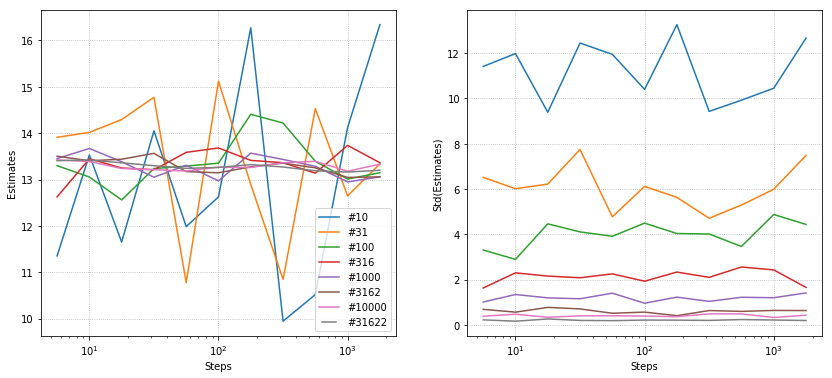

In [25]:
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
for i in range(len(paths)):
    line1, = plt.semilogx(steps, table[i][:,0], label='#'+str(int(paths[i])))
plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})
plt.xlabel('Steps')
plt.ylabel('Estimates')
plt.grid(True,linestyle='dotted')

plt.subplot(1, 2, 2)
for i in range(len(paths)):
    line1, = plt.semilogx(steps, table[i][:,1], label='#'+str(int(paths[i])))
plt.xlabel('Steps')
plt.ylabel('Std(Estimates)')
plt.grid(True,linestyle='dotted')

plt.show()

Again, it appears that 10000 simulations (paths) are enough to provide fairly good estimates. From the next plot, we see also that 252 is also a choice for the number of steps.

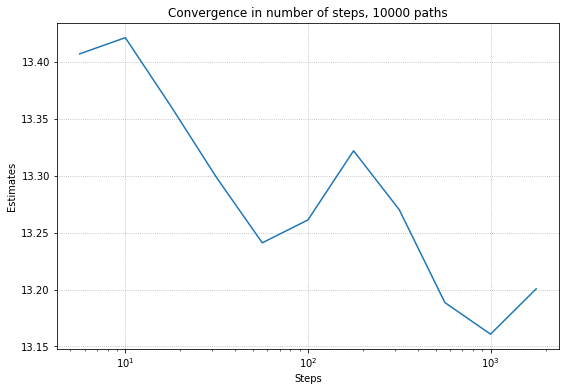

In [26]:
# Plot results

plt.figure(figsize=(9,6))

plt.semilogx(steps, table[-1][:,0])

plt.xlabel('Steps')
plt.ylabel('Estimates')
plt.title('Convergence in number of steps, 10000 paths')

plt.grid(True,linestyle='dotted')

plt.show()

Time it takes to run a simulation:

In [27]:
spot, strike, T, lmbda, eps, k, rho = df2.loc[9][:7]

In [28]:
%%timeit
# 10000 paths 2520 steps
MonteCarlo_Heston(spot, strike, T, lmbda, eps, k, rho, 10000, int(252*T))

5.78 s ± 227 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


---

## 4. 

### a. 

In [29]:
import scipy
from scipy.optimize import minimize

For calibration we need a cost function. We choose to implement the squared error cost function:

In [30]:
market = [[70, 0.17],
          [100,0.15],
          [130,0.155]]

In [31]:
def cost_SABR(x):
    sqrError = 0.0
    for mk in market:
        sqrError += (sigma(100, mk[0], 3, x[0], x[1], 1, x[2])-mk[1])**2
    return sqrError

In [32]:
# Minimize the cost function with 'Nelder-Mead'
res = minimize(cost_SABR, [0.15,0.3,0.3], method='Nelder-Mead'); res

 final_simplex: (array([[ 0.1461293 ,  0.34886076, -0.09292217],
       [ 0.14612755,  0.34888214, -0.09286287],
       [ 0.14613046,  0.34881715, -0.09291876],
       [ 0.14613727,  0.348765  , -0.09295047]]), array([  4.15804569e-12,   7.59232139e-12,   1.51476974e-11,
         2.01701207e-11]))
           fun: 4.1580456944742974e-12
       message: 'Optimization terminated successfully.'
          nfev: 103
           nit: 57
        status: 0
       success: True
             x: array([ 0.1461293 ,  0.34886076, -0.09292217])

`'Optimization terminated successfully.'` 

The calibrated parameters are: 

In [33]:
x = res.x; x

array([ 0.1461293 ,  0.34886076, -0.09292217])

In [34]:
# Check the volatilites
for K in [70,100,130]:
    print('K =', K,':\t',sigma(100, K, 3, x[0], x[1], 1, x[2]))

K = 70 :	 0.170001134305
K = 100 :	 0.149998674154
K = 130 :	 0.15499894476


The smile produced by this calibrated model is depicted below:

In [35]:
strikes = np.arange(50,155,5)
vols = [sigma(100, strike, 3, x[0], x[1], 1, x[2]) for strike in strikes]

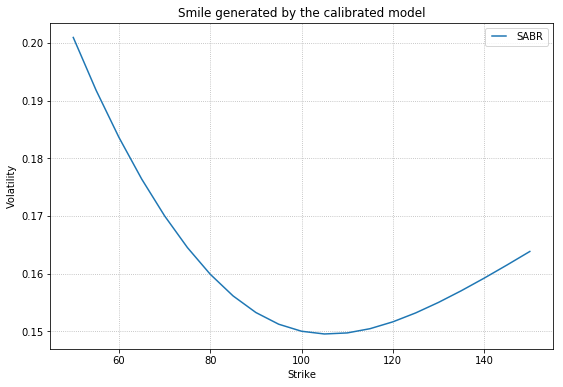

In [36]:
# Plot results
plt.figure(figsize=(9,6))

line1, = plt.plot(strikes, vols, label='SABR')

plt.xlabel('Strike')
plt.ylabel('Volatility')
plt.title('Smile generated by the calibrated model')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})
plt.grid(True,linestyle='dotted')

plt.show()

### b. 

This exercise is conducted in 2 steps:

1. Calibrate $\lambda$ ATM so as to produce the market price

2. Fix $\lambda$, find $\epsilon$ and $\rho$ to fit the prices of 2 other options

Since we have a Monte Carlo implementation of the Heston model, we will use a global optimization algorithm.
This is quiet slow. Local averaging and interpolation could be implemented to speed up things, or even better: Finate Difference Methods.

Calibration is run twice, first with a lower tolerance, then with a higher one, more simulations and with the optimization outcome as the new input.

In [37]:
# Fix some arbitrary, but realistic epsilon and rho
func = lambda x: (MonteCarlo_Heston(100, 100, 3, x[0], 0.5, 0.1, 0.3, 3000, int(100*T)) 
                  - BlackScholes(sigma=0.15, T=3))**2

In [39]:
# Find lambda
res = minimize(func, [0.14581058], method='Nelder-Mead', tol=1e-7); res

 final_simplex: (array([[ 0.15218979],
       [ 0.15218979]]), array([  1.32915253e-07,   1.38274599e-02]))
           fun: 1.3291525264856536e-07
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 200
           nit: 73
        status: 1
       success: False
             x: array([ 0.15218979])

In [41]:
lmbda = res.x[0]
func([lmbda])

0.005483007390359681

Now that we have calibrated the $\lambda$ we will attempt to fit also the other parameters: $\epsilon$ and $\rho$:

In [52]:
def cost_Heston(x, k=0.1):
    sqrError = 0.0
    for mk in market:
        sqrError += (MonteCarlo_Heston(100, mk[0], 3, lmbda, x[0], k, x[1], 5000, int(100*T))
                     - BlackScholes(S=100, K=mk[0], sigma=mk[1], T=3))**2
    return sqrError

In [53]:
# Minimize the cost function with 'Nelder-Mead'
res = minimize(cost_Heston, [ 0.57203624,  0.30248391], method='Nelder-Mead', tol=1e-4); res

 final_simplex: (array([[ 0.60045186,  0.30257792],
       [ 0.60045186,  0.30257792],
       [ 0.60045186,  0.30257792]]), array([ 0.06729965,  0.37904545,  0.41726584]))
           fun: 0.067299651079296655
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 400
           nit: 152
        status: 1
       success: False
             x: array([ 0.60045186,  0.30257792])

In [54]:
x = res.x
cost_Heston(x)

0.68679929817808605

In [ ]:
# Implied Volatility
def impliedVol(strike, price):
    return scipy.optimize.bisect(lambda x: BlackScholes(sigma = x, K = strike, T=3) - price, a = 1e-16, b = 20)

In [ ]:
vols = [impliedVol(strike, MonteCarlo_Heston(100, strike, 3, lmbda, x[0], 0.1, x[1],
                                             100000, int(252*T))) for strike in strikes]

In [ ]:
# Plot results
plt.figure(figsize=(9,6))

line1, = plt.plot(strikes, vols, label='Heston')

plt.xlabel('Strike')
plt.ylabel('Volatility')
plt.title('')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})
plt.grid(True,linestyle='dotted')

plt.show()

Further analysis skipped due to the computational hurdle.

Finate Difference Methods should be used.

---

## 5.

Essentially identically as above.

---
## 6.

In [55]:
# Bachelier's Formula
def Bachelier(S = 100, K = 100, sigma = 10, T = 10):
    d = (S - K) / (sigma * np.sqrt(T))
    return (S - K) * norm.cdf(d) + sigma * np.sqrt(T) * norm.pdf(d)

In [56]:
# Implied Volatility
def impliedVol(strike, price):
    return scipy.optimize.brentq(lambda x: BlackScholes(sigma = x, K = strike) - price, a = 1e-10, b = 10)

In [57]:
strikes = np.arange(20,200)
iVols = [impliedVol(strike = K, price = Bachelier(K = K)) for K in strikes]

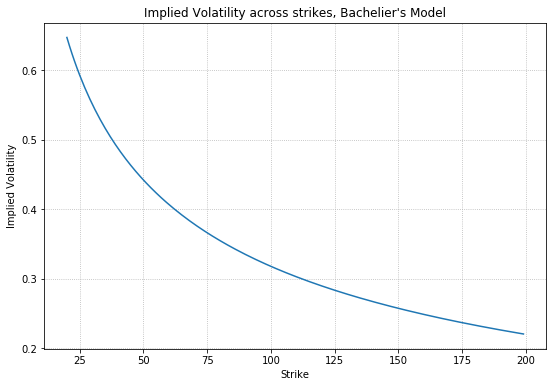

In [58]:
plt.figure(figsize=(9,6))

line1, = plt.plot(strikes, iVols)

plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility across strikes, Bachelier\'s Model')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})
plt.grid(True,linestyle='dotted')

plt.show()

### a.

In [59]:
# Store Bachelier results
market = np.array([strikes, iVols]).T

In [60]:
def cost_SABR(x):
    sqrError = 0.0
    for mk in market:
        sqrError += (sigma(100, mk[0], 10, x[0], x[1], 1, x[2])-mk[1])**2
    return sqrError

In [61]:
# Minimize the cost function with 'Nelder-Mead'
res = minimize(cost_SABR, [0.15,0.3,0.3], method='Nelder-Mead'); res

 final_simplex: (array([[ 0.45566332,  0.90167519, -0.61271106],
       [ 0.45566224,  0.90173744, -0.6127148 ],
       [ 0.45568561,  0.90176905, -0.61271205],
       [ 0.45570487,  0.90176714, -0.61271241]]), array([ 0.04590035,  0.04590035,  0.04590035,  0.04590035]))
           fun: 0.045900345303605587
       message: 'Optimization terminated successfully.'
          nfev: 242
           nit: 136
        status: 0
       success: True
             x: array([ 0.45566332,  0.90167519, -0.61271106])

`'Optimization terminated successfully.'` 

The calibrated parameters are: 

In [62]:
x = res.x; x

array([ 0.45566332,  0.90167519, -0.61271106])

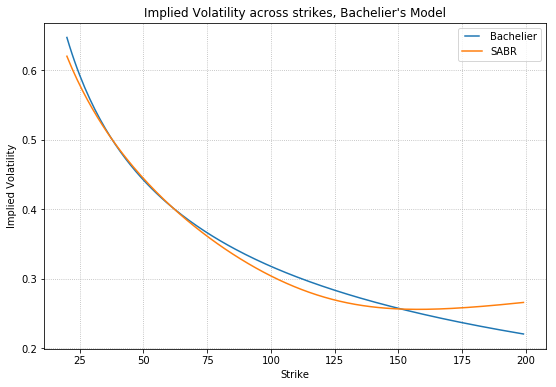

In [63]:
# Plot results
plt.figure(figsize=(9,6))

line1, = plt.plot(strikes, iVols, label='Bachelier')
line2, = plt.plot(strikes, [sigma(100, strike, 10, x[0], x[1], 1, x[2]) 
                            for strike in strikes], label='SABR')

plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility across strikes, Bachelier\'s Model')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})
plt.grid(True,linestyle='dotted')

plt.show()

The fit is not really perfect. SABR seems to display more convexity than Bachelier.

### b.

In [64]:
def cost_SABR(x):
    sqrError = 0.0
    for mk in market:
        sqrError += (sigma(100, mk[0], 10, x[0], x[1], x[2], 0)-mk[1])**2
    return sqrError

In [65]:
# Minimize the cost function with 'Nelder-Mead'
res = minimize(cost_SABR, [0.15,0.3,0.3], method='Nelder-Mead'); res

 final_simplex: (array([[  1.99200830e+01,   2.19769311e-06,   9.34276136e-02],
       [  1.99201004e+01,   8.79417881e-07,   9.34275190e-02],
       [  1.99200819e+01,  -4.41397715e-06,   9.34276044e-02],
       [  1.99200233e+01,  -2.06549863e-06,   9.34283410e-02]]), array([ 0.0021314,  0.0021314,  0.0021314,  0.0021314]))
           fun: 0.0021313957781283368
       message: 'Optimization terminated successfully.'
          nfev: 417
           nit: 236
        status: 0
       success: True
             x: array([  1.99200830e+01,   2.19769311e-06,   9.34276136e-02])

`'Optimization terminated successfully.'` 

The calibrated parameters are: 

In [66]:
x = res.x; x

array([  1.99200830e+01,   2.19769311e-06,   9.34276136e-02])

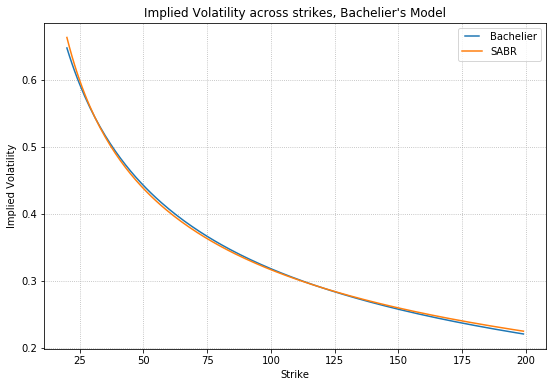

In [67]:
# Plot results
plt.figure(figsize=(9,6))

line1, = plt.plot(strikes, iVols, label='Bachelier')
line2, = plt.plot(strikes, [sigma(100, strike, 10, x[0], x[1], x[2], 0) 
                            for strike in strikes], label='SABR')

plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility across strikes, Bachelier\'s Model')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})
plt.grid(True,linestyle='dotted')

plt.show()

Much better. 

### c. 

Same procedure as described in point 4.

---

### d.

The price will be given by:

$$Heston\left(S_T+\frac{1-a}{a}S_0, K+\frac{1-a}{a}S_0, \lambda a\right)$$

---

---

# Question 3: Dupire simulation

## 1. Merton model implementation


In [68]:
import math

In [200]:
def Merton(S=100, sigma=0.15, lmbda=0.1, m=-0.05, v=0.0225, K=100, T=3):
    price = 0.0
    comp = lmbda*(np.exp(m+0.5*v)-1)
    for n in range(20):
        spot = S * np.exp(n*(m+0.5*v)-comp*T)
        vol = np.sqrt(sigma**2+n*v/T)
        price += BlackScholes(S=spot, K=K, sigma=vol, T=T) * np.exp(-lmbda*T)/math.factorial(n)*(lmbda*T)**n
    return price

In [70]:
Merton()

10.823389628821344

---

## 2. Monte-Carlo simulations for a Dupire fitted to the Merton market

We will attempt to implement the first scenario.

For $Merton_KK$, we know that Black Scholes formula is a homogeneous function of degree one, and so we can appy Euler's Theorem to find the first derivative:

$$\frac{\partial BS}{\partial K} = -N(d2)$$

The second order derivative with respect to strike, becomes:

\begin{align*}
    \frac{\partial^2 BS}{\partial K^2} & = -n(d2) \frac{\partial d2}{\partial K}\\
    & = \frac{n(d2)}{K\sigma\sqrt{T}}
\end{align*}

The analytical solution for Merton's theta benefits from the following derivations:

\begin{align*}
	\frac{\partial}{\partial T} \left(BS\left(T\right)\frac{e^{-\lambda T}}{n!}(\lambda T)^n\right) & = \frac{\partial}{\partial T} BS\left(T\right) 
    \frac{e^{-\lambda T}}{n!}(\lambda T)^n + BS\left(T\right) \frac{\partial}{\partial T} \left(\frac{e^{-\lambda T}}{n!}(\lambda T)^n\right)\\
& = \left(-comp \cdot spot\cdot N\left(d1\right) + spot\cdot n\left(d1\right) \frac{\partial d1}{\partial T} -K n\left(d2\right)\frac{\partial d2}{\partial T}\right)\frac{e^{-\lambda T}}{n!}(\lambda T)^n \\
& \quad + BS\left(T\right) \frac{e^{-\lambda T}}{T n!}(\lambda T)^n\left(n-T\lambda \right)\\
\end{align*}

with 
$$\frac{\partial d1}{\partial T} = -\frac{comp}{vol\sqrt{T}}-\ln\left(\frac{spot}{K}\right)\frac{\sigma^2}{2 (vol\sqrt{T})^3}+\frac{\sigma^2}{4vol\sqrt{T}}$$
$$\frac{\partial d2}{\partial T} = \frac{\partial d1}{\partial T} - \frac{\sigma^2}{2vol\sqrt{T}}$$

Alternatively, to find $Merton_T$, we may simply use an approximation $\left(Merton(\cdot,T+\epsilon)-Merton(\cdot,T)\right)/\epsilon$.

In [247]:
def MonteCarlo_Dupire(S, sigma, lmbda, m, v, K, T, nPaths, nSteps):
    dt = T / nSteps
    logS = np.full(nPaths, np.log(S))
    comp = lmbda*(np.exp(m+0.5*v)-1)
    
    for i in range(nSteps):
        Ti = T - i*dt
        Si = np.exp(logS)
        
        M_T = 0.0
        M_KK = 0.0
        for n in range(20):
            spot = S * np.exp(n*(m+0.5*v)-comp*Ti)
            vol = np.sqrt(sigma**2+n*v/Ti)
            std = vol*np.sqrt(Ti)
                   
            d1 = np.log(spot/Si) / std + 0.5*std
            d2 = d1 - std
            
            dd1 = -comp/std - 0.5*np.log(spot/Si)*sigma**2/std**3 + 0.25*sigma**2/std
            dd2 = dd1 - 0.5*sigma**2/std
            
#             M_T += (-comp*spot*norm.cdf(d1) + spot*norm.pdf(d1)*dd1 - Si*norm.pdf(d2)*dd2) \
#                 * np.exp(-lmbda*T)/math.factorial(n)*(lmbda*T)**n\
#                 + BlackScholes(S=spot, K=Si, sigma=vol, T=Ti) \
#                 * np.exp(-lmbda*T)/(T*math.factorial(n))*(lmbda*T)**n*(n-lmbda*T)
                
            M_KK += scipy.stats.norm.pdf(d2)/(Si*std) \
                * np.exp(-lmbda*Ti)/math.factorial(n)*(lmbda*Ti)**n
        
        
        M0 = Merton(S, sigma, lmbda, m, v, np.exp(logS), Ti)
        eps = 1e-4 / (10*i+1)
        M_T = (Merton(S, sigma, lmbda, m, v, np.exp(logS), Ti + eps)-M0) / eps

        # Compute LV
        LV = np.sqrt(2*M_T / (K**2*M_KK))
#         print(LV[:2])
        logS = logS - 0.5*LV**2*dt + LV*np.sqrt(dt) * np.random.normal(size=nPaths)

    return np.mean(np.maximum(np.exp(logS) - K, 0))

---
## 3.

In [250]:
MonteCarlo_Dupire(100, 0.15, 0.1, -0.05, 0.0225, 100, 3, 1000, 300)

11.063007864038438

The result is close to our Merton result:

In [244]:
Merton()

10.823389628821344